In [1]:
import __init__
from __init__ import DATA_PATH
from __init__ import PACKAGE_PATH
import numpy as np
import pandas as pd
import os
import matplotlib as mplt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import utilities
from descriptor import rdkitDescriptors

In [3]:
df=pd.read_csv(os.path.join(DATA_PATH,'BOD_RDKit_Descriptors_1063.csv'))
df['cleaned_bod'] =utilities.clean_out_of_bound(df['value (% BOD)'])

## 1 Divide the feature columns by dtypes (float and int)

### 1.1 int features

In [5]:
feat_int = rdkitDescriptors.batch_compute_all_descriptors(df['SMILES'],desc_type='int')
selected_int_feat = feat_int.loc[:,feat_int.nunique()>1]
len(selected_int_feat.loc[0])

59

### 1.2 float features

In [6]:
feat_float =rdkitDescriptors.batch_compute_all_descriptors(df['SMILES'],desc_type='float')
selected_float_feat = feat_float.loc[:,feat_float.nunique()>1]
len(selected_float_feat.loc[0])

68

### 1.3 int+float

In [36]:
feat_all = rdkitDescriptors.batch_compute_all_descriptors(df['SMILES'],desc_type='all')
selected_all_feat = feat_all.loc[:,feat_all.nunique()>1]
len(selected_all_feat.loc[0])

127

### 1.4 Autocorrelation

In [4]:
auto_corr = rdkitDescriptors.batch_compute_aauto_2D_coorelation(df['SMILES'])

## 2 Divide BOD by different cutoff

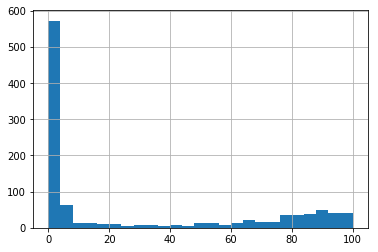

In [7]:
df['cleaned_bod'].hist(bins=25)

### 2.1 50% quantile two classes

(array([535.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 528.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

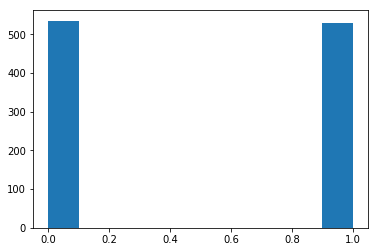

In [8]:
df['bi_class_q50']=pd.qcut(df['cleaned_bod'].values, 2, labels=[0,1])
true_label_q50 = df['bi_class_q50'].values
plt.hist(true_label_q50)

### 2.2 33%, 66% quantile 3 classes (manual implement due to duplicate edges)

(array([413.,   0.,   0.,   0.,   0., 288.,   0.,   0.,   0., 362.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

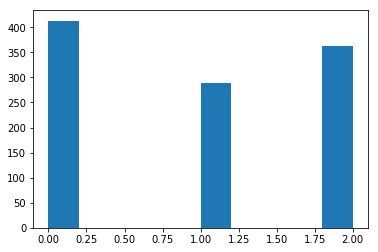

In [9]:
tri_cuts=df['cleaned_bod'].quantile([0.33,0.66]).values
df['tri_class_q33']=utilities.divide_classes(df['cleaned_bod'], tri_cuts)
true_label_q33=df['tri_class_q33'].values
plt.hist(true_label_q33)

### 2.3 25%, 50%, 75% 4 classes (manual)

(array([413.,   0.,   0., 122.,   0.,   0., 262.,   0.,   0., 266.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

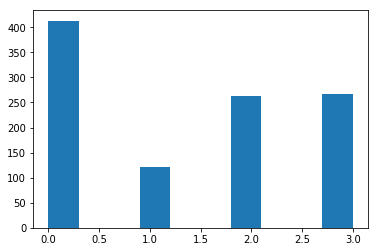

In [10]:
quart_cuts=df['cleaned_bod'].quantile([0.25,0.50,0.75]).values
df['quart_class_q25']=utilities.divide_classes(df['cleaned_bod'], quart_cuts)
true_label_q25 = df['quart_class_q25'].values
plt.hist(true_label_q25) #inbalanced

In [11]:
quart_cuts

array([ 0.  ,  2.  , 68.85])

### 2.4 Partitioning into bi classes based on distribution

(array([756.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 307.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

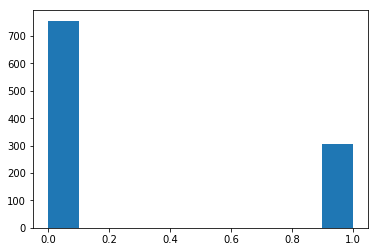

In [12]:
df['bi_class_partition']=utilities.divide_classes(df['cleaned_bod'], [60])
true_label_biclass = df['bi_class_partition'].values
plt.hist(df['bi_class_partition'])

### 2.5 Partitioning into three classes (poor, median, good) based on distribution

(array([673.,   0.,   0.,   0.,   0., 191.,   0.,   0.,   0., 199.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

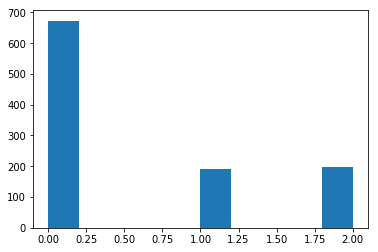

In [13]:
df['tri_class_partition']=utilities.divide_classes(df['cleaned_bod'], [20,80])
true_label_triclass = df['tri_class_partition'].values
plt.hist(df['tri_class_partition'])

## 3 Baseline Model -- Kmeans

In [14]:
from cluster import KMeans

Using TensorFlow backend.


## 3.1 bi-class 50 quantile cluster

### 3.1.1 int feature

In [15]:
kmeans_cluster = KMeans(n_clusters=2)
kmeans_cluster.bulid_kmeans_cluster()
kmeans_cluster.train_model(selected_int_feat.values, true_labels=true_label_q50)

Metrics without ture labels
silhouette score: 0.5631770710744006
calinski score: 662.268614258969
davie bouldin score: 0.978204839784849

Metric with True label
adjusted rand score: 0.004008772230807742 
adjusted mutual info score: 0.005417666040987789
homogeneity completeness v measure:
(0.006095085864171074, 0.010843282439520381, 0.007803672270360499)
fowlkes_mallows : 0.6222514591435622


/Users/hunting/miniconda3/envs/deepchembed/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/hunting/miniconda3/envs/deepchembed/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


(array([0, 0, 0, ..., 1, 0, 0], dtype=int32),
 {'silhouette_score': 0.5631770710744006,
  'calinski_score': 662.268614258969,
  'davie_bouldin_score': 0.978204839784849,
  'adjusted_rand_score': 0.004008772230807742,
  'adjusted_mutual_info_score': 0.005417666040987789,
  'homogeneity_completeness_v_measure': (0.006095085864171074,
   0.010843282439520381,
   0.007803672270360499),
  'fowlkes_mallows_score': 0.6222514591435622})

(array([923.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 140.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

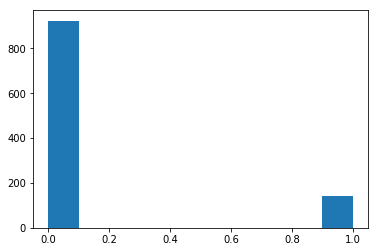

In [16]:
plt.hist(kmeans_cluster.model.labels_)

### 3.1.2 float feature

In [17]:
kmeans_cluster = KMeans(n_clusters=2)
kmeans_cluster.bulid_kmeans_cluster()
kmeans_cluster.train_model(selected_float_feat.values, true_labels=true_label_q50)

Metrics without ture labels
silhouette score: 0.9772635201713795
calinski score: 2453.85631403476
davie bouldin score: 0.015261182984337367

Metric with True label
adjusted rand score: -2.4617415490710395e-05 
adjusted mutual info score: -8.89558430810096e-06
homogeneity completeness v measure:
(0.0009324855614722467, 0.08622182815151025, 0.0018450173355687419)
fowlkes_mallows : 0.7061152060370829


/Users/hunting/miniconda3/envs/deepchembed/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/hunting/miniconda3/envs/deepchembed/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


(array([0, 0, 0, ..., 0, 0, 0], dtype=int32),
 {'silhouette_score': 0.9772635201713795,
  'calinski_score': 2453.85631403476,
  'davie_bouldin_score': 0.015261182984337367,
  'adjusted_rand_score': -2.4617415490710395e-05,
  'adjusted_mutual_info_score': -8.89558430810096e-06,
  'homogeneity_completeness_v_measure': (0.0009324855614722467,
   0.08622182815151025,
   0.0018450173355687419),
  'fowlkes_mallows_score': 0.7061152060370829})

(array([1.062e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

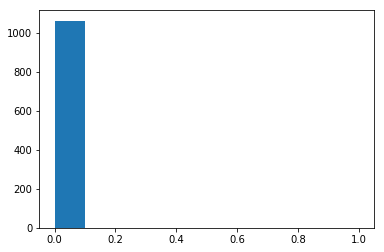

In [18]:
plt.hist(kmeans_cluster.model.labels_)

with normalization on features

In [22]:
from keras.utils import normalize
selected_float_feat_norm = normalize(selected_float_feat.values, axis=0, order=2)

In [25]:
kmeans_cluster = KMeans(n_clusters=2)
kmeans_cluster.bulid_kmeans_cluster()
kmeans_cluster.train_model(selected_float_feat_norm, true_labels=true_label_q50)

Metrics without ture labels
silhouette score: 0.3395621309170745
calinski score: 142.46901685006003
davie bouldin score: 2.3145365366875423

Metric with True label
adjusted rand score: 0.0010426783754876891 
adjusted mutual info score: 0.0016601517629590086
homogeneity completeness v measure:
(0.002339411347379388, 0.003344020082250553, 0.0027529279179817154)
fowlkes_mallows : 0.5888401083971747


/Users/hunting/miniconda3/envs/deepchembed/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/hunting/miniconda3/envs/deepchembed/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


(array([0, 0, 0, ..., 1, 1, 0], dtype=int32),
 {'silhouette_score': 0.3395621309170745,
  'calinski_score': 142.46901685006003,
  'davie_bouldin_score': 2.3145365366875423,
  'adjusted_rand_score': 0.0010426783754876891,
  'adjusted_mutual_info_score': 0.0016601517629590086,
  'homogeneity_completeness_v_measure': (0.002339411347379388,
   0.003344020082250553,
   0.0027529279179817154),
  'fowlkes_mallows_score': 0.5888401083971747})

(array([862.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 201.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

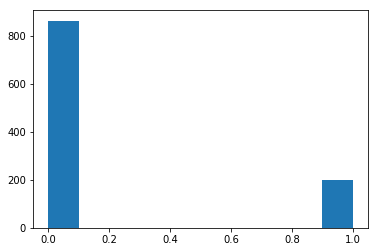

In [26]:
plt.hist(kmeans_cluster.model.labels_)

### 3.1.3 All

In [37]:
selected_all_feat_norm = normalize(selected_all_feat.values, axis=0, order=2)
kmeans_cluster = KMeans(n_clusters=2)
kmeans_cluster.bulid_kmeans_cluster()
kmeans_cluster.train_model(selected_all_feat_norm, true_labels=true_label_q50)

Metrics without ture labels
silhouette score: 0.33918579116507447
calinski score: 103.57096065288427
davie bouldin score: 2.6996124909810426

Metric with True label
adjusted rand score: 0.0013784645403367229 
adjusted mutual info score: 0.002173477679230612
homogeneity completeness v measure:
(0.0028524550819760837, 0.00417328970104597, 0.0033887144449293786)
fowlkes_mallows : 0.5929902134511599


/Users/hunting/miniconda3/envs/deepchembed/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/hunting/miniconda3/envs/deepchembed/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


(array([1, 0, 0, ..., 1, 0, 0], dtype=int32),
 {'silhouette_score': 0.33918579116507447,
  'calinski_score': 103.57096065288427,
  'davie_bouldin_score': 2.6996124909810426,
  'adjusted_rand_score': 0.0013784645403367229,
  'adjusted_mutual_info_score': 0.002173477679230612,
  'homogeneity_completeness_v_measure': (0.0028524550819760837,
   0.00417328970104597,
   0.0033887144449293786),
  'fowlkes_mallows_score': 0.5929902134511599})

## 3.2 Comparison between different cuts

1. bi-class 50 quantile cluster
2. tri-class 33 quantile cluster
3. quart-class 25 quantile cluster
4. bi-class with customed partition \[0,60\%\], (60\%,100\%\]
5. tri-class with customed partition \[0,20\%\], (20\%,80\%\], (80\%,100\%\]

In [28]:
n_clusters   = [2, 3, 4, 2, 3]
true_labels  = [true_label_q50, true_label_q33, true_label_q25, true_label_biclass, true_label_triclass]
cluster_name = ['bi_class_50_quantile', 'tri_class_33_quantile', 
                'quart_class_25_quantile', 'bi_class_customed_partition','tri_class_customed_partition']

### 3.2.1 int feature

In [29]:
kmeans_cluster = KMeans(n_clusters=2)
metrics = []
for i in range(len(n_clusters)):
    kmeans_cluster.n_clusters = n_clusters[i]
    kmeans_cluster.bulid_kmeans_cluster()
    a, metric = kmeans_cluster.train_model(selected_int_feat.values, 
                                           true_labels=true_labels[i],
                                           print_metric=False)
    metrics.append(metric)

/Users/hunting/miniconda3/envs/deepchembed/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/hunting/miniconda3/envs/deepchembed/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/Users/hunting/miniconda3/envs/deepchembed/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/hunting/miniconda3/envs/deepchembed/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AM

/Users/hunting/miniconda3/envs/deepchembed/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/hunting/miniconda3/envs/deepchembed/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/Users/hunting/miniconda3/envs/deepchembed/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/hunting/miniconda3/envs/deepchembed/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AM

In [30]:
int_metrics_df = pd.DataFrame(columns=metrics[0].keys())
int_metrics_df['clusters'] = cluster_name
int_metrics_df = int_metrics_df.set_index('clusters')

for i in range(len(metrics)):
    int_metrics_df.loc[cluster_name[i]] = pd.Series(metrics[i])

int_metrics_df

,silhouette_score,calinski_score,davie_bouldin_score,adjusted_rand_score,adjusted_mutual_info_score,homogeneity_completeness_v_measure,fowlkes_mallows_score
clusters,,,,,,,
bi_class_50_quantile,0.561092,662.248,0.982046,0.00452089,0.00610937,"(0.006786286257876708, 0.011964447935782916, 0...",0.621346
tri_class_33_quantile,0.336812,524.598,1.31905,0.0182244,0.0215097,"(0.023211516759650063, 0.030759319969463697, 0...",0.428058
quart_class_25_quantile,0.328079,481.518,1.21571,0.0225912,0.0338063,"(0.03703659147184899, 0.05153548351715117, 0.0...",0.383118
bi_class_customed_partition,0.561092,662.248,0.982046,0.0101362,-0.000301087,"(0.0004853675935659653, 0.0007420797180312165,...",0.676009
tri_class_customed_partition,0.336812,524.598,1.31905,-0.011541,0.0246171,"(0.026646814364769584, 0.02958471061181734, 0....",0.483427


### 3.2.1 float feature

In [31]:
kmeans_cluster = KMeans(n_clusters=2)
metrics = []
for i in range(len(n_clusters)):
    kmeans_cluster.n_clusters = n_clusters[i]
    kmeans_cluster.bulid_kmeans_cluster()
    a, metric = kmeans_cluster.train_model(selected_float_feat_norm, 
                                           true_labels=true_labels[i],
                                           print_metric=False)
    metrics.append(metric)

/Users/hunting/miniconda3/envs/deepchembed/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/hunting/miniconda3/envs/deepchembed/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/Users/hunting/miniconda3/envs/deepchembed/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/hunting/miniconda3/envs/deepchembed/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AM

/Users/hunting/miniconda3/envs/deepchembed/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/hunting/miniconda3/envs/deepchembed/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/Users/hunting/miniconda3/envs/deepchembed/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/hunting/miniconda3/envs/deepchembed/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AM

In [32]:
float_metrics_df = pd.DataFrame(columns=metrics[0].keys())
float_metrics_df['clusters'] = cluster_name
float_metrics_df = float_metrics_df.set_index('clusters')

for i in range(len(metrics)):
    float_metrics_df.loc[cluster_name[i]] = pd.Series(metrics[i])

float_metrics_df

,silhouette_score,calinski_score,davie_bouldin_score,adjusted_rand_score,adjusted_mutual_info_score,homogeneity_completeness_v_measure,fowlkes_mallows_score
clusters,,,,,,,
bi_class_50_quantile,0.340837,142.462,2.30984,0.00104689,0.00168093,"(0.0023601955308827243, 0.0033929784663812913,...",0.589838
tri_class_33_quantile,0.332421,125.231,1.6994,0.00281395,0.00323555,"(0.005082278810522517, 0.010675575829776535, 0...",0.485468
quart_class_25_quantile,0.261684,109.758,2.11278,0.0077221,0.0200195,"(0.023386056687418447, 0.036891217267625925, 0...",0.398794
bi_class_customed_partition,0.339562,142.469,2.31454,-0.0323044,0.00639071,"(0.007170874158586804, 0.008889015882678044, 0...",0.627035
tri_class_customed_partition,0.33536,125.23,1.69272,-0.030255,0.00555268,"(0.007796119528799571, 0.013871657037170934, 0...",0.55604


In [38]:
kmeans_cluster = KMeans(n_clusters=2)
metrics = []
for i in range(len(n_clusters)):
    kmeans_cluster.n_clusters = n_clusters[i]
    kmeans_cluster.bulid_kmeans_cluster()
    a, metric = kmeans_cluster.train_model(selected_all_feat_norm, 
                                           true_labels=true_labels[i],
                                           print_metric=False)
    metrics.append(metric)

/Users/hunting/miniconda3/envs/deepchembed/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/hunting/miniconda3/envs/deepchembed/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/Users/hunting/miniconda3/envs/deepchembed/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/hunting/miniconda3/envs/deepchembed/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AM

/Users/hunting/miniconda3/envs/deepchembed/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/hunting/miniconda3/envs/deepchembed/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)
/Users/hunting/miniconda3/envs/deepchembed/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/Users/hunting/miniconda3/envs/deepchembed/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AM

In [40]:
all_metrics_df = pd.DataFrame(columns=metrics[0].keys())
all_metrics_df['clusters'] = cluster_name
all_metrics_df = all_metrics_df.set_index('clusters')

for i in range(len(metrics)):
    all_metrics_df.loc[cluster_name[i]] = pd.Series(metrics[i])
    
all_metrics_df

,silhouette_score,calinski_score,davie_bouldin_score,adjusted_rand_score,adjusted_mutual_info_score,homogeneity_completeness_v_measure,fowlkes_mallows_score
clusters,,,,,,,
bi_class_50_quantile,0.339186,103.571,2.69961,0.00137846,0.00217348,"(0.0028524550819760837, 0.00417328970104597, 0...",0.59299
tri_class_33_quantile,0.320279,88.234,2.07395,0.010359,0.00863396,"(0.010470442075445296, 0.021008283542767684, 0...",0.482538
quart_class_25_quantile,0.272,81.9958,2.22189,0.0106634,0.027763,"(0.031106582758775498, 0.052610119009936646, 0...",0.413132
bi_class_customed_partition,0.339186,103.571,2.69961,-0.0376474,0.00928746,"(0.01006545072257529, 0.012770627654259107, 0....",0.629584
tri_class_customed_partition,0.333329,88.3045,2.01024,-0.0354547,0.00972719,"(0.011961352081565877, 0.021586486029454087, 0...",0.556225


In [41]:
float_metrics_df

,silhouette_score,calinski_score,davie_bouldin_score,adjusted_rand_score,adjusted_mutual_info_score,homogeneity_completeness_v_measure,fowlkes_mallows_score
clusters,,,,,,,
bi_class_50_quantile,0.340837,142.462,2.30984,0.00104689,0.00168093,"(0.0023601955308827243, 0.0033929784663812913,...",0.589838
tri_class_33_quantile,0.332421,125.231,1.6994,0.00281395,0.00323555,"(0.005082278810522517, 0.010675575829776535, 0...",0.485468
quart_class_25_quantile,0.261684,109.758,2.11278,0.0077221,0.0200195,"(0.023386056687418447, 0.036891217267625925, 0...",0.398794
bi_class_customed_partition,0.339562,142.469,2.31454,-0.0323044,0.00639071,"(0.007170874158586804, 0.008889015882678044, 0...",0.627035
tri_class_customed_partition,0.33536,125.23,1.69272,-0.030255,0.00555268,"(0.007796119528799571, 0.013871657037170934, 0...",0.55604


In [33]:
int_metrics_df

,silhouette_score,calinski_score,davie_bouldin_score,adjusted_rand_score,adjusted_mutual_info_score,homogeneity_completeness_v_measure,fowlkes_mallows_score
clusters,,,,,,,
bi_class_50_quantile,0.561092,662.248,0.982046,0.00452089,0.00610937,"(0.006786286257876708, 0.011964447935782916, 0...",0.621346
tri_class_33_quantile,0.336812,524.598,1.31905,0.0182244,0.0215097,"(0.023211516759650063, 0.030759319969463697, 0...",0.428058
quart_class_25_quantile,0.328079,481.518,1.21571,0.0225912,0.0338063,"(0.03703659147184899, 0.05153548351715117, 0.0...",0.383118
bi_class_customed_partition,0.561092,662.248,0.982046,0.0101362,-0.000301087,"(0.0004853675935659653, 0.0007420797180312165,...",0.676009
tri_class_customed_partition,0.336812,524.598,1.31905,-0.011541,0.0246171,"(0.026646814364769584, 0.02958471061181734, 0....",0.483427
